In [1]:
import torch
import pickle 
import os
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import matplotlib as mpl
import copy
import sys
import matplotlib as mpl
from sklearn.cluster import KMeans
from scipy.ndimage import gaussian_filter, binary_opening, binary_closing


# Get the parent directory of the current directory
project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)
    
from diffusion_proc import Diffusion, linear_noise_schedule
from unet import Unet
from dataset import CondSeqImageDataset

VOL_PATH = "/vol/bitbucket/ag323"

In [2]:
DATA_DIR = os.path.join(VOL_PATH, "diss_ag/data/evaluation_data") #"C:/Users/Anirbit/Desktop/MSc/Ind Project/Msc-Project/data/evaluation_data"
MODEL_PATH = os.path.join(VOL_PATH, "diss_ag/results/ckpts/gde_ensemble_model_4_64x64_simData_10000samples_fixedParams.pt") # "C:/Users/Anirbit/Desktop/MSc/Ind Project/Msc-Project/results/ckpts/gde_ensemble_model_4_64x64_simData_10000samples_fixedParams.pt"

(64, 64)


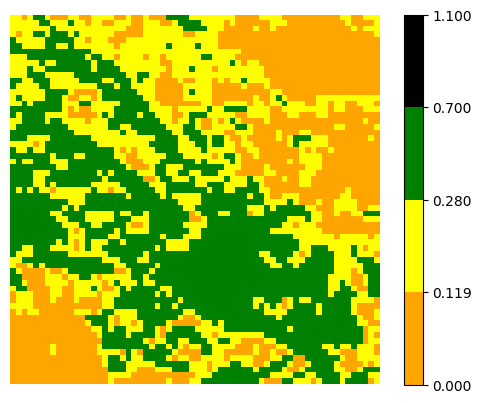

In [9]:
# custormize colorbar
cmap = mpl.colors.ListedColormap(['orange','yellow', 'green', 'black'])
cmap.set_over('0.25')
cmap.set_under('0.75')
bounds =  [0.0,0.1188,0.2798,0.7,1.1] #[0.0,0.2488,0.3098,0.7,1.1] # [1.0, 2.02, 2.27, 3.5, 5.1]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

BACKGROUND_PATH = os.path.join(VOL_PATH, "diss_ag/data/background.mpy") # "C:/Users/Anirbit/Desktop/MSc/Ind Project/Msc-Project/
with open(BACKGROUND_PATH, 'rb') as f:
    background_img = pickle.load(f)
    print(background_img.shape)

plt.imshow(background_img, cmap=cmap, norm=norm)
plt.colorbar()
plt.axis("off")
plt.show()

# binary custom cmap
binary_cmap = mpl.colors.ListedColormap(['blue', 'black', 'red'])

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
diff_model =  Unet(
    in_ch=1,
    cond_ch=1,
    model_ch=96,
    output_ch=1,
    channel_mult=(1, 2, 2),
    attn_res=[],
)
diff_model.load_state_dict(torch.load(MODEL_PATH))
diff_model.to(device)

Unet(
  (time_emb): Sequential(
    (0): Linear(in_features=96, out_features=384, bias=True)
    (1): SiLU()
    (2): Linear(in_features=384, out_features=384, bias=True)
  )
  (downsample_blocks): ModuleList(
    (0): TimestepSeqEmbedding(
      (0): Conv2d(1, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1-2): 2 x TimestepSeqEmbedding(
      (0): ResBlock(
        (conv_1): Sequential(
          (0): GroupNorm(32, 96, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (time_embedding): Sequential(
          (0): SiLU()
          (1): Linear(in_features=384, out_features=96, bias=True)
        )
        (condition_conv): Sequential(
          (0): Conv2d(1, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): SiLU()
        )
        (conv_2): Sequential(
          (0): GroupNorm(32, 96, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Dropout(

In [5]:
transform = transforms.Compose([
    transforms.ToTensor()
])

simulated_data = CondSeqImageDataset(DATA_DIR, transform=transform)

In [32]:
def plot_images_in_row(images, starting_image=None, type_output="simulation", mismatch_stat=None):
    """
    Function to plot 5 images in a single row, side by side.

    Parameters:
    - images: List or array of 5 images to be plotted.
    - starting_image: An optional starting image to be displayed in the first subplot.
    """

    # Ensure the input images are in a list or array and exactly 5 images
    assert len(images) == 4, "The images array must contain exactly 4 images."
    
    # Create a figure with a grid layout with 1 row and 6 columns
    fig, axes = plt.subplots(1, 4, figsize=(12, 6))

    # # Plot the starting image if provided
    # if starting_image is not None:
    #     if type_output != "mismatch":
    #         start_img = starting_image.cpu().squeeze().squeeze()
    #         combined_img = np.where(start_img == 1, 1, background_img)
    #         axes[0].imshow(combined_img, cmap=cmap, interpolation="none", norm=norm)
    #         axes[0].set_title('Starting State t=0')
    #         axes[0].axis('off')
    #     else:
    #         axes[0].imshow(starting_image.cpu().squeeze().squeeze(), cmap="binary_r")
    #         axes[0].set_title('Starting State t=0')
    #         axes[0].axis('off')
    # else:
    #     axes[0].axis('off')  # Hide the first subplot if no starting image is provided

    # Plot the 5 images
    for i in range(4):
        if type_output != "mismatch":
            img = images[i]
            combined_img = np.where(img == 1, 1, background_img)
            axes[i].imshow(combined_img, cmap=cmap, interpolation="none", norm=norm)
            if type_output=="simulation":
                axes[i].set_title(f'Simulated t = {(i+1) * 5}')
            elif type_output=="predicted":
                axes[i].set_title(f'Predicted t = {(i+1) * 5}')
            axes[i].axis('off')
        else:
            img = images[i]
            over_perc, under_perc, total_mismatch = mismatch_stat[i]
            axes[i].imshow(img, cmap=binary_cmap)
            axes[i].set_title(f'Mismatch')
            axes[i].axis('off')

    # Adjust the layout
    plt.tight_layout()
    plt.show()
    

In [28]:
diffusion = Diffusion(timesteps=500, noise_schedule='linear')

def generate_predictions(t_0, diff_client, num_preds=4):
    
    input_img = t_0

    input_img = input_img.to(device).float().unsqueeze(0)
    image_size = input_img.shape[-1]
    channels = input_img.shape[1]

    input_arr = [input_img]
    outputs = []
    for i in range(num_preds):
        generated_images = diff_client.sample(
            model=diff_model,
            image_size=image_size,
            cond_img=input_arr[-1],
            batch_size=1,  # Set the desired batch size
            channels=channels,
            w=2,
            clip_denoised=True
        )
        otpt = generated_images[-1].squeeze().squeeze()
        otpt = np.where(otpt <= 0.5, 0, otpt)
        otpt = np.where(otpt > 0.5, 1, otpt)
        
        outputs.append(otpt)
        
        
        next_input = transform(otpt).to(device).float().unsqueeze(0)
        input_arr.append(next_input)

    return outputs

def compute_pixel_mismatch(image1, image2):
    """
    Compute the pixel mismatch between two binary images and return a binary image representing the mismatch.

    Parameters:
    - image1: numpy array representing the first binary image.
    - image2: numpy array representing the second binary image.

    Returns:
    - mismatch_image: A binary image where mismatched pixels are 1 and matching pixels are 0.
    - mismatch_percentage: The percentage of mismatched pixels.
    - over_under_estimate: An image where:
        - 1 represents overestimated pixels (present in image1 but not in image2),
        - -1 represents underestimated pixels (present in image2 but not in image1),
        - 0 represents matching pixels.
    """
    # Convert torch tensors to numpy arrays if needed
    if isinstance(image1, torch.Tensor):
        image1 = image1.numpy()
    if isinstance(image2, torch.Tensor):
        image2 = image2.numpy()
        
    # Ensure both images have the same shape
    if image1.shape != image2.shape:
        raise ValueError("The two images must have the same dimensions.")
    
    # Compute the mismatch by comparing the images
    mismatch_image = (image1 != image2).astype(int)  # Convert boolean array to integer array
    
    # Calculate the percentage of mismatched pixels
    total_pixels = image1.size
    mismatched_pixels = np.sum(mismatch_image)
    mismatch_percentage = round((mismatched_pixels / total_pixels) * 100, 3)
    
    # Create over_under_estimate image
    over_under_estimate = np.zeros_like(image1, dtype=int)
    
    # Label overestimated pixels as 1 (present in image1 but not in image2)
    over_under_estimate[(image1 == 1) & (image2 == 0)] = 1
    
    # Label underestimated pixels as -1 (present in image2 but not in image1)
    over_under_estimate[(image1 == 0) & (image2 == 1)] = -1

    # Calculate the percentages
    overestimated_pixels = np.sum(over_under_estimate == 1)
    underestimated_pixels = np.sum(over_under_estimate == -1)
    overestimate_percentage = round((overestimated_pixels / total_pixels) * 100, 3)
    underestimate_percentage = round((underestimated_pixels / total_pixels) * 100, 3)
    
    return mismatch_image, over_under_estimate, overestimate_percentage, underestimate_percentage, mismatch_percentage


0 16


sampling loop time step: 100%|████████████████████████████████████████████████████████| 500/500 [00:11<00:00, 43.30it/s]


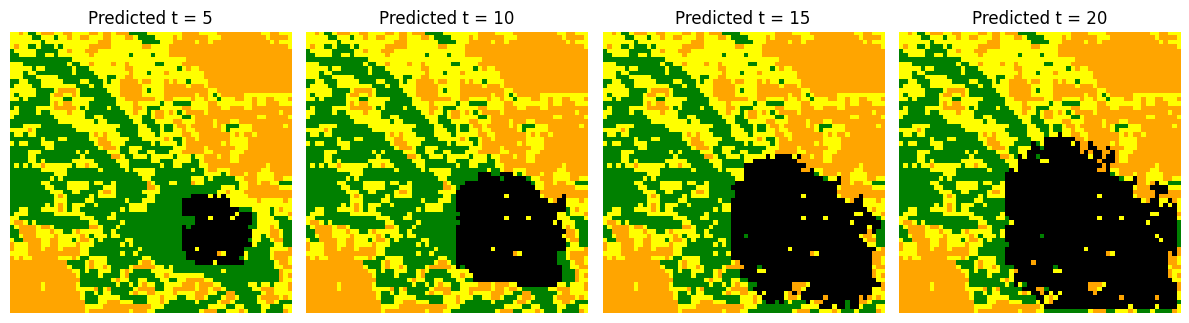

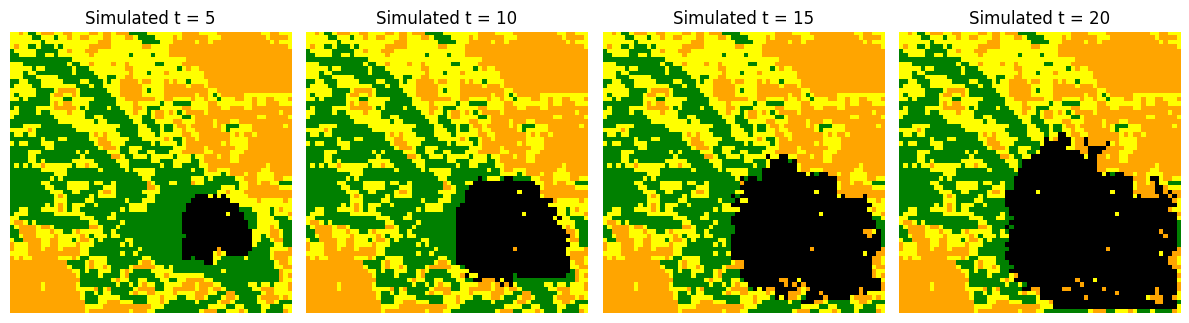

overestimate: 0.708% | underestimate: 0.464%, total mismatch: 1.172%
overestimate: 1.587% | underestimate: 0.781%, total mismatch: 2.368%
overestimate: 2.417% | underestimate: 1.343%, total mismatch: 3.76%
overestimate: 2.246% | underestimate: 1.855%, total mismatch: 4.102%


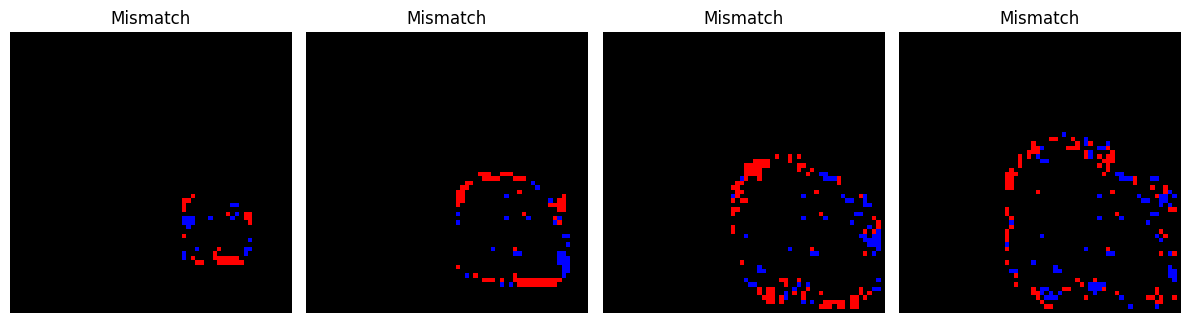

16 32


sampling loop time step: 100%|████████████████████████████████████████████████████████| 500/500 [00:11<00:00, 42.46it/s]


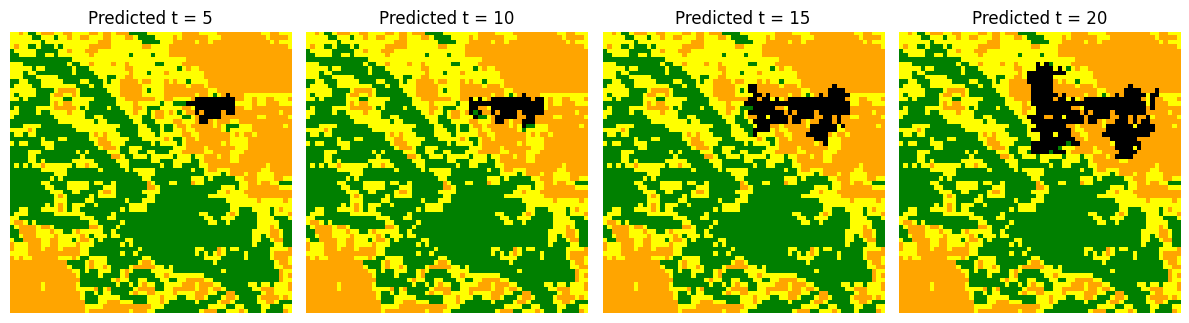

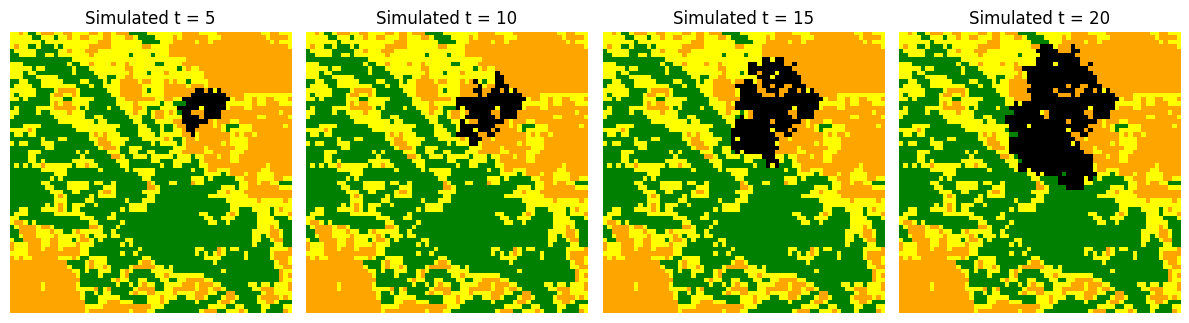

overestimate: 0.269% | underestimate: 0.854%, total mismatch: 1.123%
overestimate: 0.684% | underestimate: 1.953%, total mismatch: 2.637%
overestimate: 1.758% | underestimate: 4.492%, total mismatch: 6.25%
overestimate: 2.905% | underestimate: 7.104%, total mismatch: 10.01%


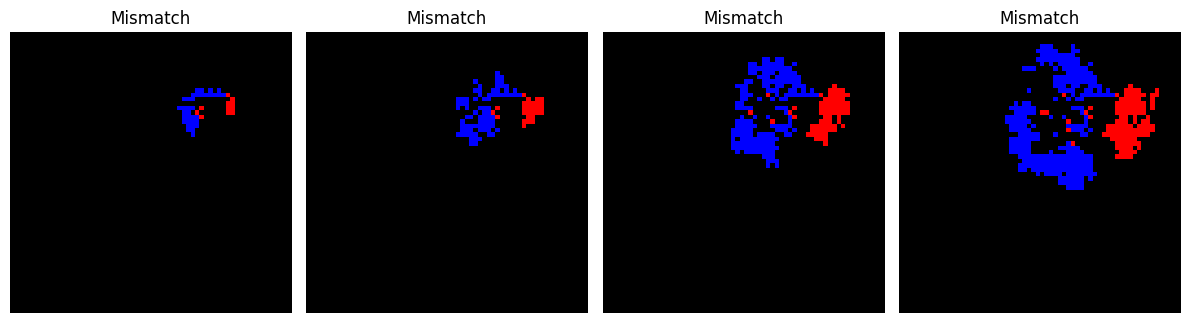

32 48


sampling loop time step: 100%|████████████████████████████████████████████████████████| 500/500 [00:11<00:00, 43.21it/s]


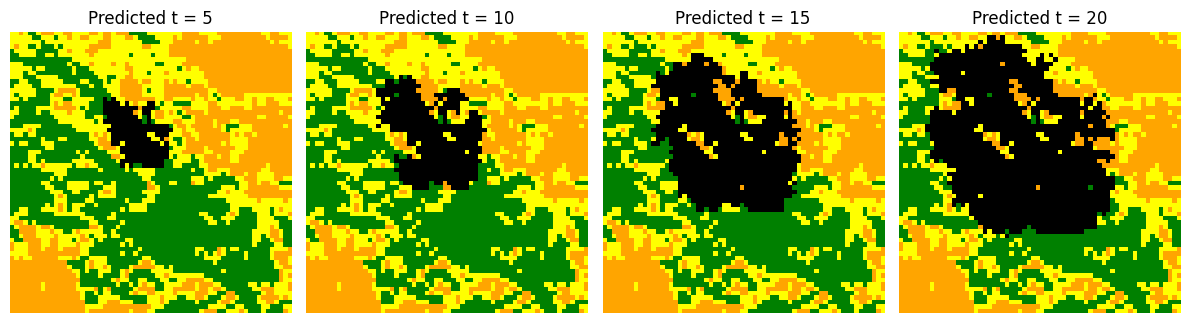

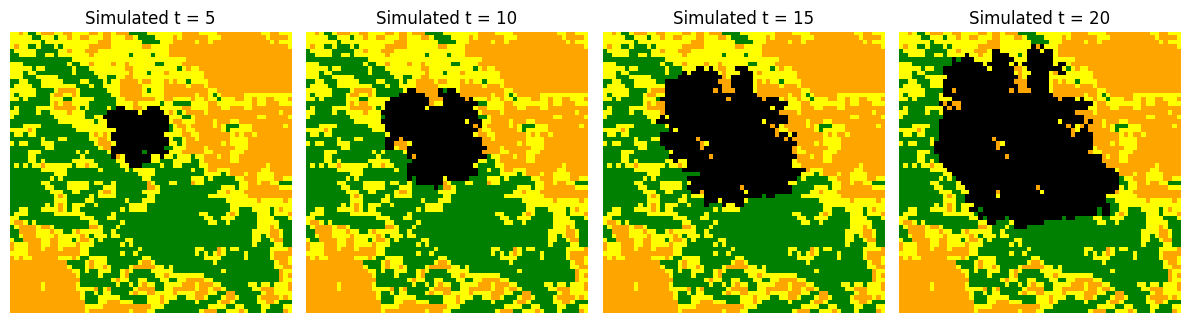

overestimate: 0.928% | underestimate: 0.781%, total mismatch: 1.709%
overestimate: 2.026% | underestimate: 1.562%, total mismatch: 3.589%
overestimate: 4.37% | underestimate: 2.075%, total mismatch: 6.445%
overestimate: 6.763% | underestimate: 2.979%, total mismatch: 9.741%


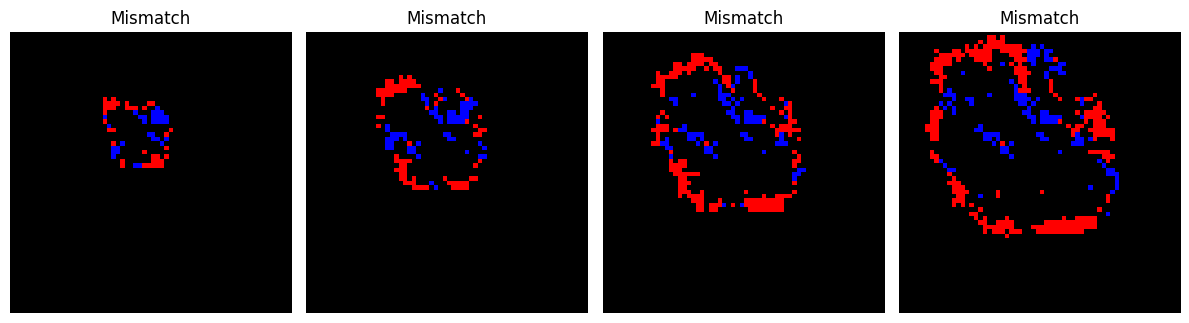

48 64


sampling loop time step: 100%|████████████████████████████████████████████████████████| 500/500 [00:11<00:00, 43.59it/s]


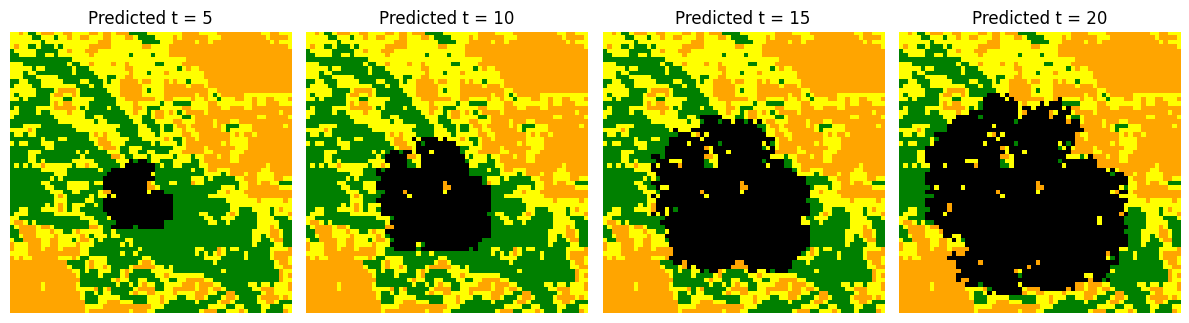

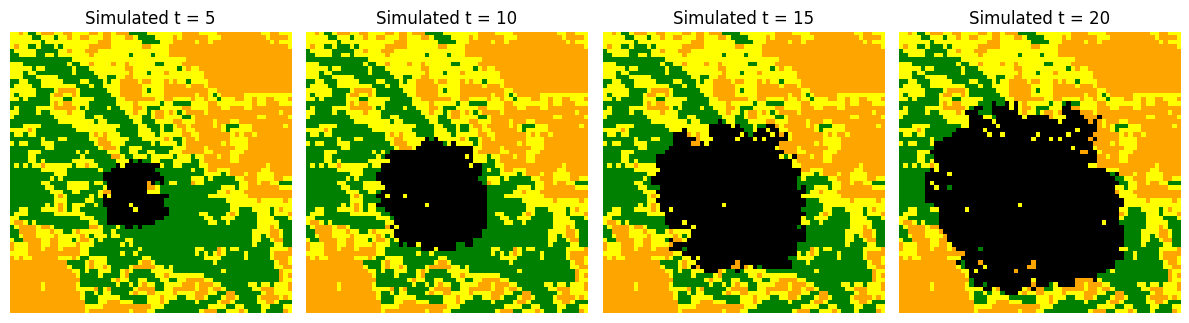

overestimate: 0.708% | underestimate: 0.342%, total mismatch: 1.05%
overestimate: 1.392% | underestimate: 1.099%, total mismatch: 2.49%
overestimate: 3.076% | underestimate: 1.807%, total mismatch: 4.883%
overestimate: 4.224% | underestimate: 3.027%, total mismatch: 7.251%


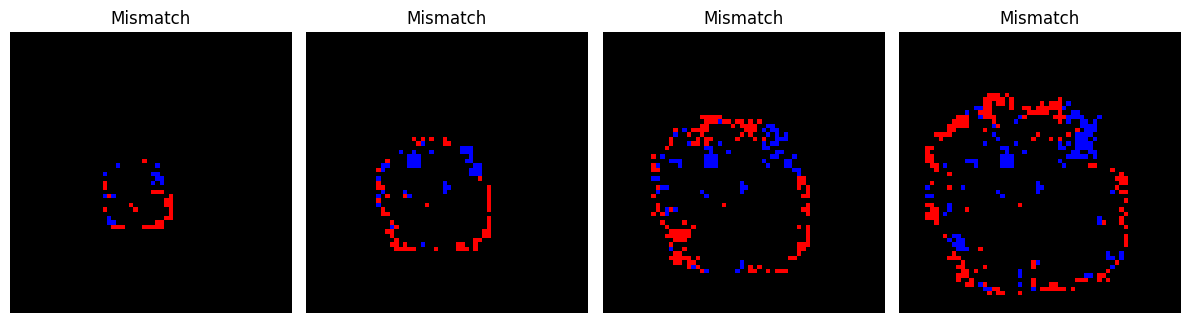

64 80


sampling loop time step: 100%|████████████████████████████████████████████████████████| 500/500 [00:11<00:00, 43.84it/s]


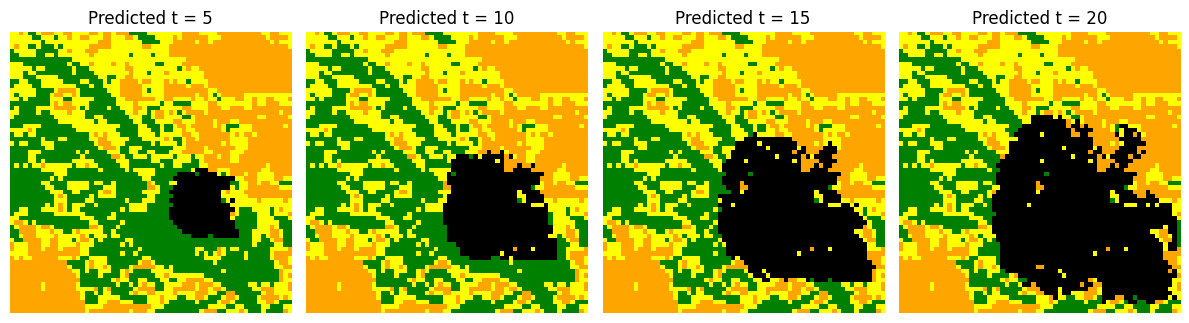

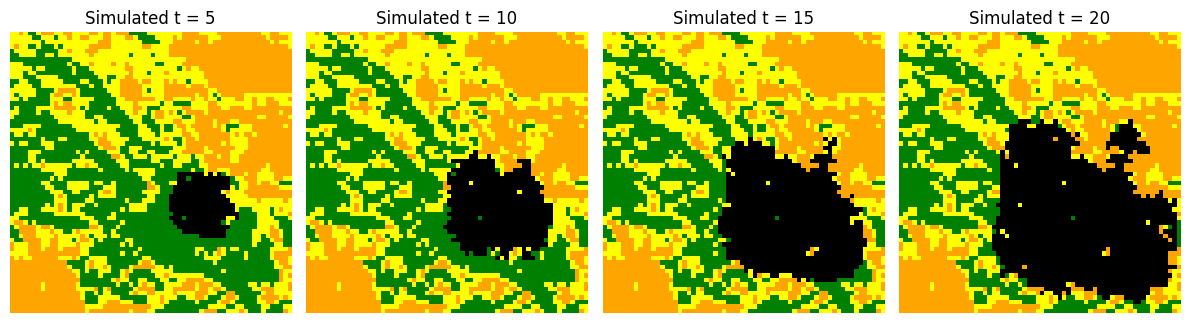

overestimate: 0.61% | underestimate: 0.293%, total mismatch: 0.903%
overestimate: 1.953% | underestimate: 0.659%, total mismatch: 2.612%
overestimate: 2.588% | underestimate: 1.245%, total mismatch: 3.833%
overestimate: 3.174% | underestimate: 2.734%, total mismatch: 5.908%


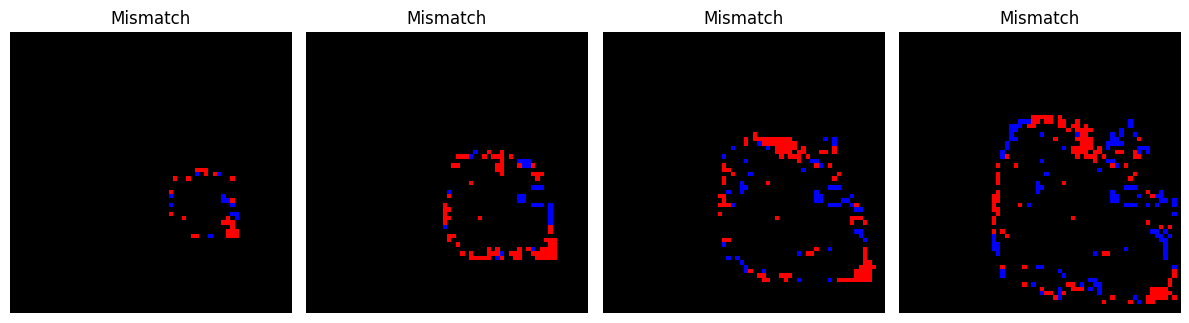

80 96


sampling loop time step: 100%|████████████████████████████████████████████████████████| 500/500 [00:11<00:00, 43.33it/s]


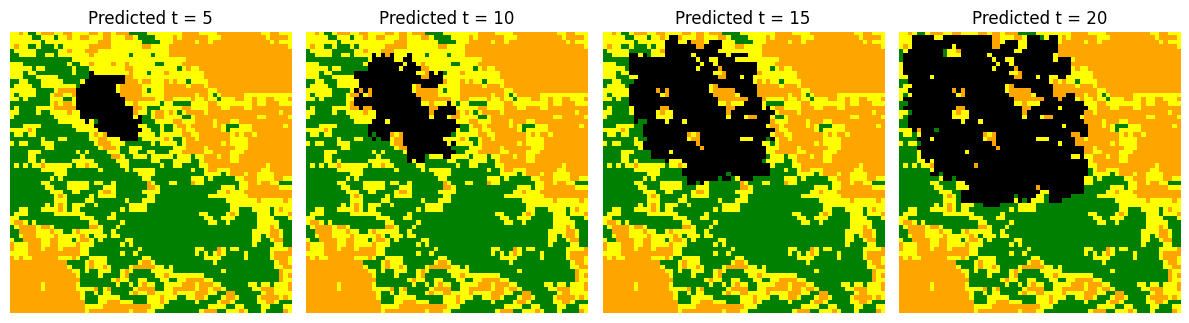

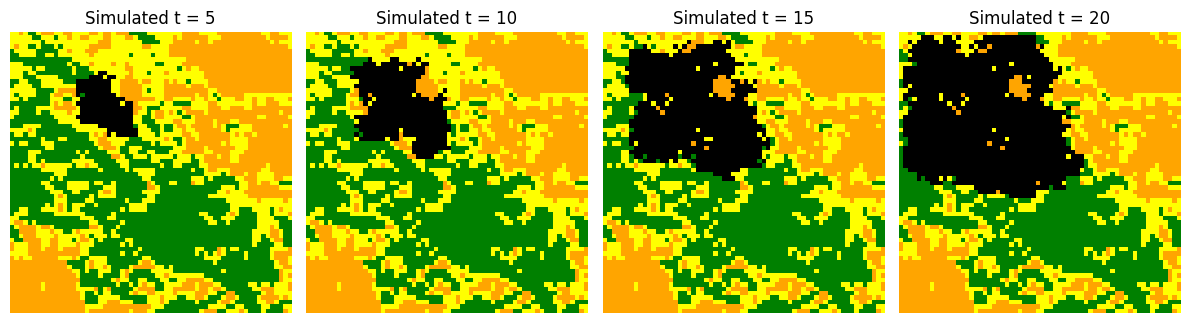

overestimate: 0.659% | underestimate: 0.269%, total mismatch: 0.928%
overestimate: 1.685% | underestimate: 1.685%, total mismatch: 3.369%
overestimate: 3.638% | underestimate: 2.979%, total mismatch: 6.616%
overestimate: 5.396% | underestimate: 4.028%, total mismatch: 9.424%


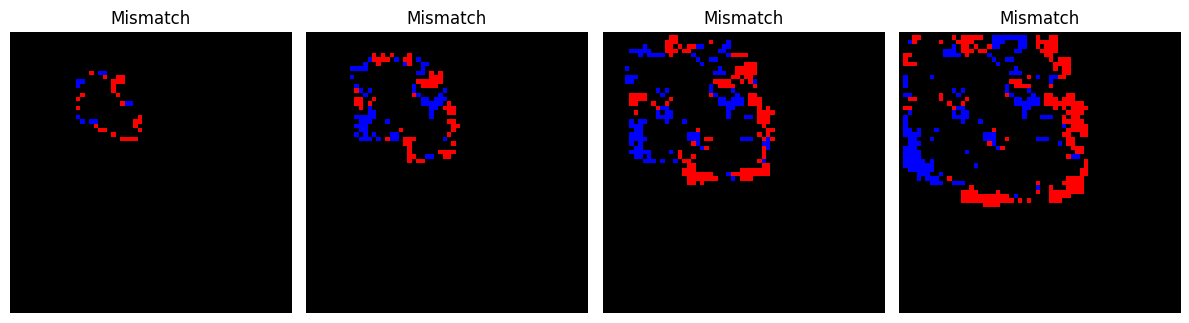

96 112


sampling loop time step: 100%|████████████████████████████████████████████████████████| 500/500 [00:11<00:00, 42.41it/s]


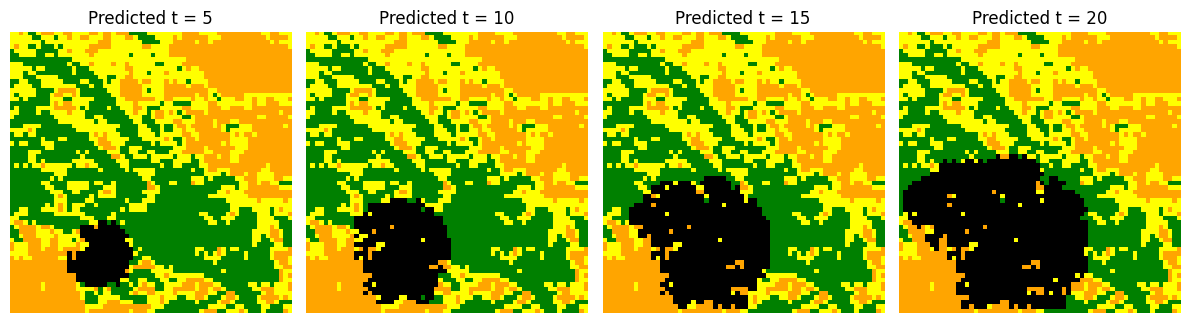

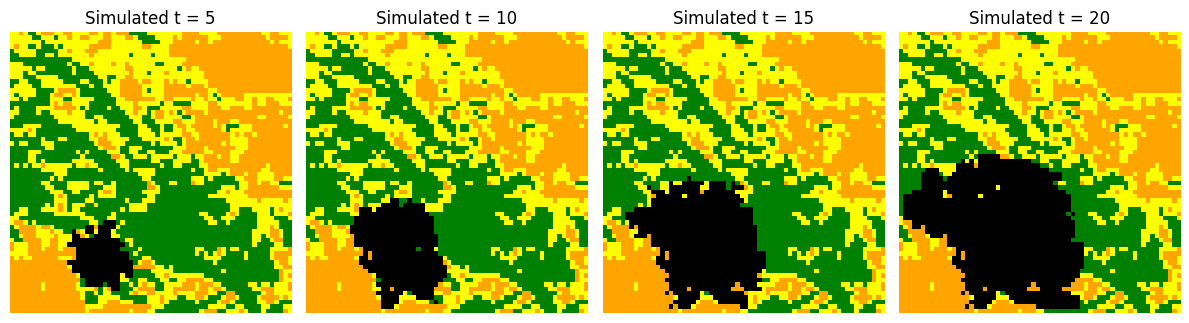

overestimate: 0.757% | underestimate: 0.562%, total mismatch: 1.318%
overestimate: 1.538% | underestimate: 0.879%, total mismatch: 2.417%
overestimate: 2.271% | underestimate: 1.099%, total mismatch: 3.369%
overestimate: 2.783% | underestimate: 1.831%, total mismatch: 4.614%


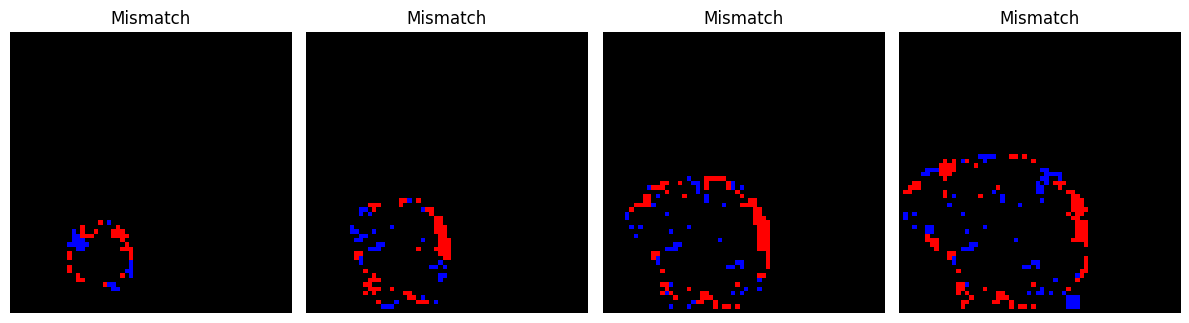

112 128


sampling loop time step: 100%|████████████████████████████████████████████████████████| 500/500 [00:11<00:00, 43.16it/s]


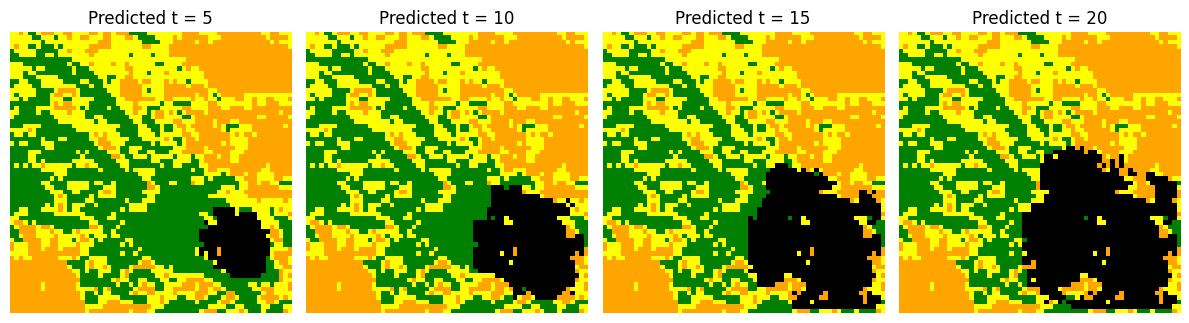

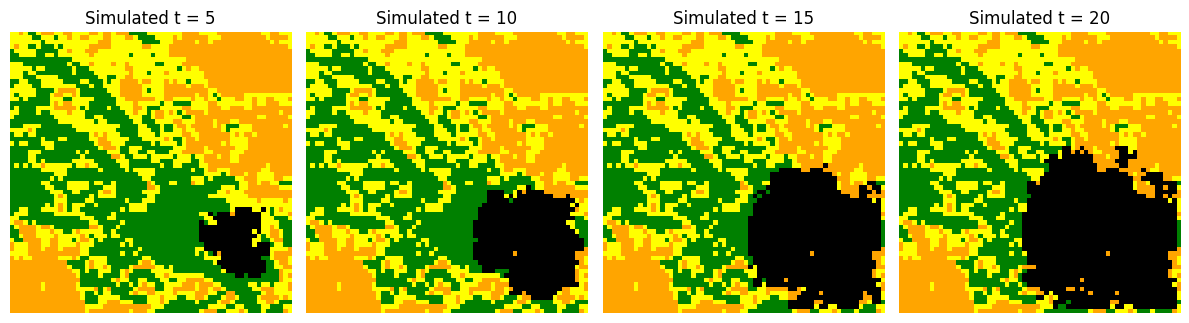

overestimate: 0.708% | underestimate: 0.342%, total mismatch: 1.05%
overestimate: 0.806% | underestimate: 1.27%, total mismatch: 2.075%
overestimate: 0.854% | underestimate: 2.417%, total mismatch: 3.271%
overestimate: 1.147% | underestimate: 3.467%, total mismatch: 4.614%


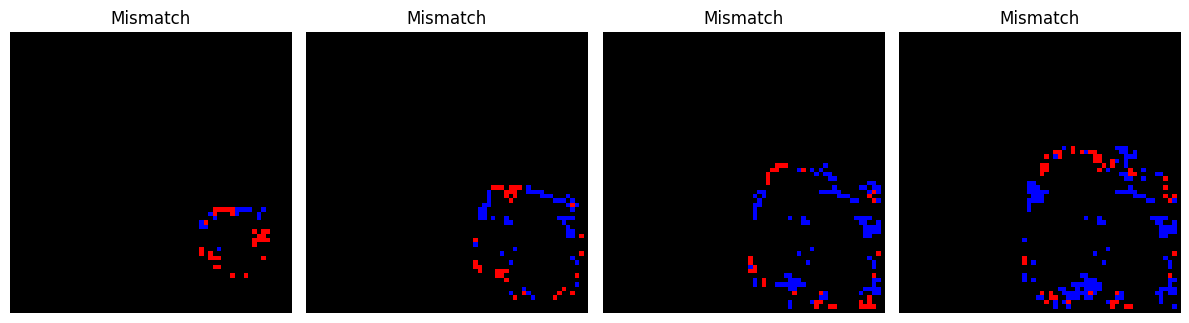

128 144


sampling loop time step: 100%|████████████████████████████████████████████████████████| 500/500 [00:11<00:00, 42.65it/s]


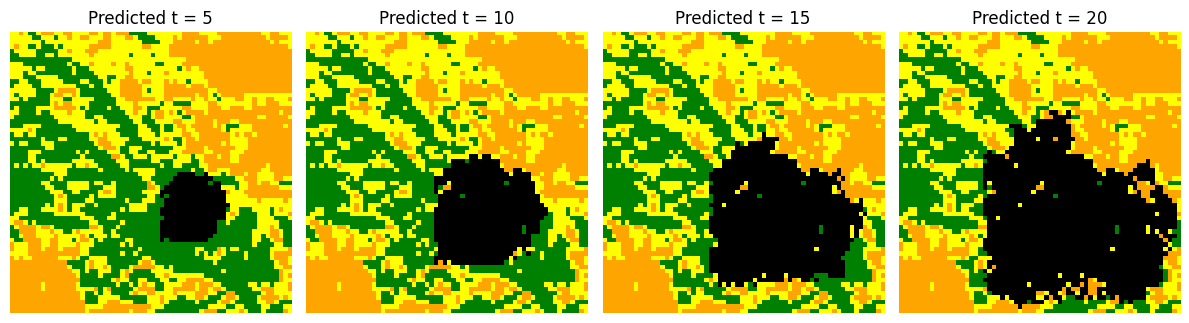

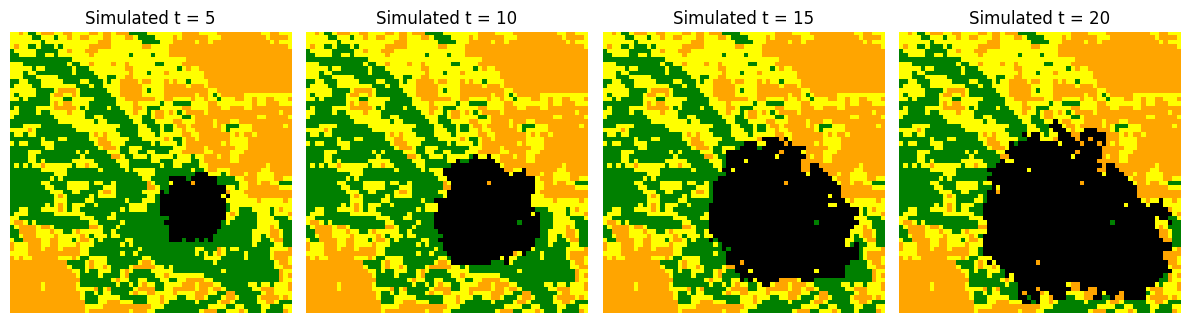

overestimate: 0.586% | underestimate: 0.317%, total mismatch: 0.903%
overestimate: 1.367% | underestimate: 0.366%, total mismatch: 1.733%
overestimate: 2.49% | underestimate: 1.587%, total mismatch: 4.077%
overestimate: 5.005% | underestimate: 2.319%, total mismatch: 7.324%


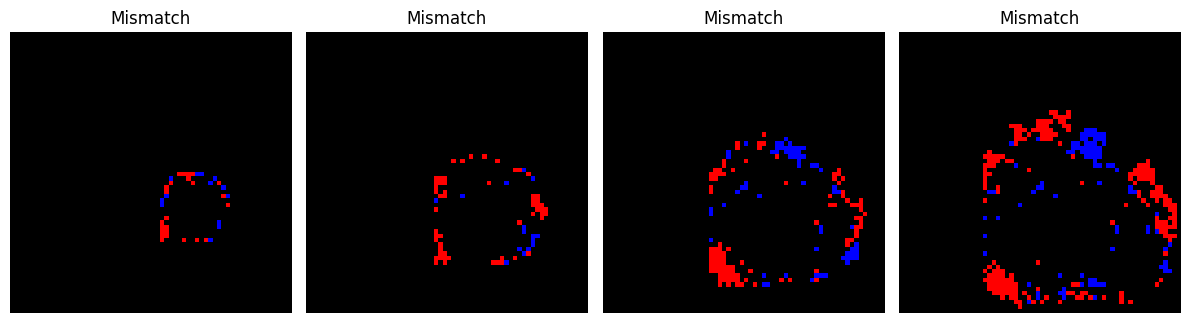

144 160


sampling loop time step: 100%|████████████████████████████████████████████████████████| 500/500 [00:11<00:00, 43.12it/s]


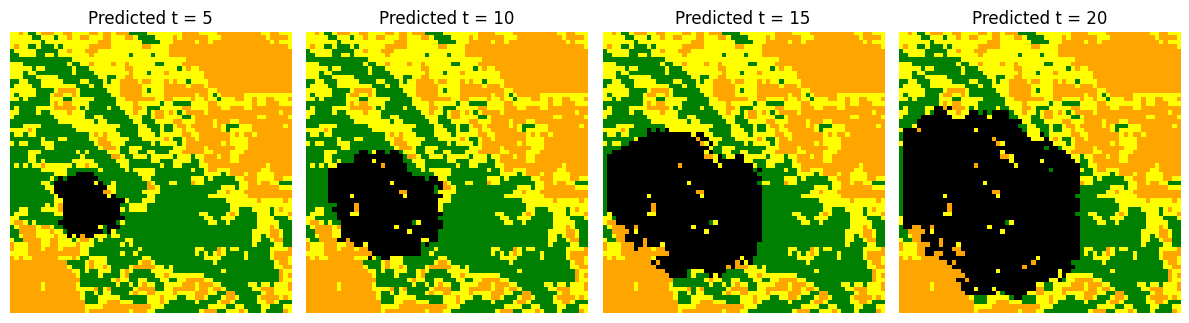

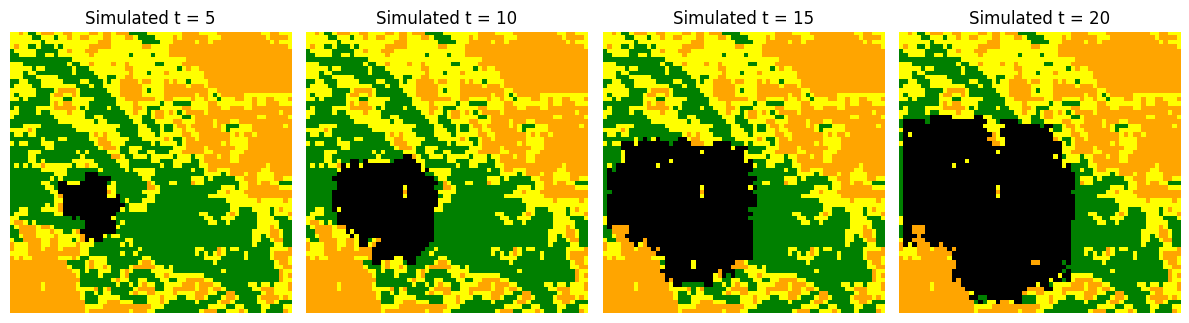

overestimate: 0.977% | underestimate: 0.439%, total mismatch: 1.416%
overestimate: 1.807% | underestimate: 1.147%, total mismatch: 2.954%
overestimate: 2.441% | underestimate: 2.148%, total mismatch: 4.59%
overestimate: 2.783% | underestimate: 2.539%, total mismatch: 5.322%


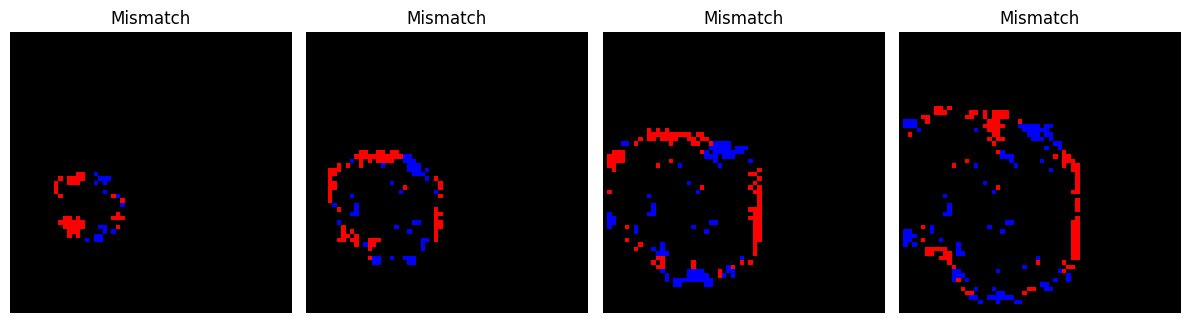

In [36]:
batch_size = 16
for batch in range(10):
    start_index = batch * batch_size
    end_index = start_index + batch_size
    print(start_index, end_index)
    
    data = [simulated_data[i] for i in range(start_index, end_index)]
    
    input_img = data[0][1]
    
    outputs = generate_predictions(input_img, diffusion)

    plot_images_in_row(outputs, type_output="predicted")

    ground_truth = []
    for i in range(0, len(data), 5):
        ground_truth.append(data[i][0].squeeze())
        
    plot_images_in_row(ground_truth)
    
    mismatch = []
    mismatch_percentages = []
    for i in range(4):
        predicted = outputs[i]
        simulated = ground_truth[i]
        mismatch_image, over_under_estimate, over_percent, under_percent, mismatch_percentage  = compute_pixel_mismatch(predicted, simulated)
        mismatch.append(over_under_estimate)
        mismatch_percentages.append((over_percent, under_percent, mismatch_percentage))
        print(f"overestimate: {over_percent}% | underestimate: {under_percent}%, total mismatch: {mismatch_percentage}%")
        
        
    plot_images_in_row(mismatch, type_output="mismatch", mismatch_stat=mismatch_percentages)
    


In [74]:
batch_size = 16
g_ts = []
ots = []
mismatches = []
mis_percs = []

for batch in range(10):
    start_index = batch * batch_size
    end_index = start_index + batch_size
    print(start_index, end_index)
    
    data = [simulated_data[i] for i in range(start_index, end_index)]
    
    input_img = data[0][1]
    
    outputs = generate_predictions(input_img, diffusion)
    ots.append(outputs)
    plot_images_in_row(outputs, input_img, type_output="predicted")

    ground_truth = []
    g_ts.append(ground_truth)
    for i in range(0, len(data), 5):
        ground_truth.append(data[i][0].squeeze())
        
    plot_images_in_row(ground_truth, input_img)
    
    mismatch = []
    mismatches.append(mismatch)
    mismatch_percentages = []
    mis_percs.append(mismatch_percentages)
    for i in range(4):
        predicted = outputs[i]
        simulated = ground_truth[i]
        mismatch_image, mismatch_percentage = compute_pixel_mismatch(predicted, simulated)
        mismatch.append(mismatch_image)
        mismatch_percentages.append(mismatch_percentage)
        
        
    plot_images_in_row(mismatch, input_img, type_output="mismatch", mismatch_stat=mismatch_percentages)


0 16


IndexError: list index out of range